In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import xgboost as xg
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## EDA

In [3]:
df.shape

(768, 9)

In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<AxesSubplot:>

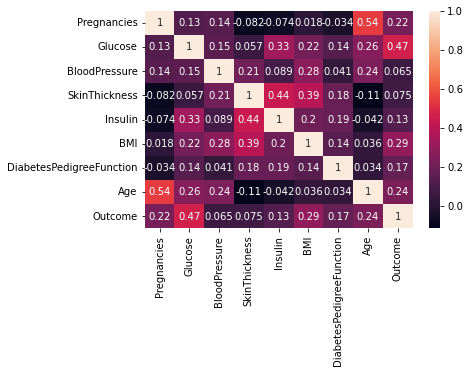

In [5]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)

In [6]:
##Calculating 0s in Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction and Age
print('Os in Glucose is:', sum(df['Glucose'] == 0))
print('Os in BloodPressure is:', sum(df['BloodPressure'] == 0))
print('Os in Skin Thickness is:', sum(df['SkinThickness'] == 0))     
print('Os in Insulin is:', sum(df['Insulin'] == 0)) 
print('Os in BMI is:', sum(df['BMI'] == 0)) 
print('Os in DiabetesPedigreeFunction is:', sum(df['DiabetesPedigreeFunction'] == 0)) 
print('Os in Age is:', sum(df['Age'] == 0)) 

Os in Glucose is: 5
Os in BloodPressure is: 35
Os in Skin Thickness is: 227
Os in Insulin is: 374
Os in BMI is: 11
Os in DiabetesPedigreeFunction is: 0
Os in Age is: 0


### Replacing 0's with Knn imputation

In [7]:
from sklearn.impute import KNNImputer
for i in [ 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']:
    df[i]=df[i].replace(0,np.nan)


imputer = KNNImputer()
# fit on the dataset
imputer.fit(df)
# transform the dataset
Xtrans = imputer.transform(df)

## Checking dataset imbalance

C:\Users\vidis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


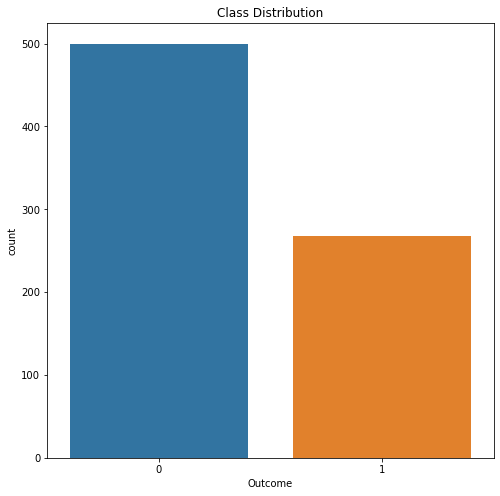

In [8]:
plt.figure(figsize=(8, 8))
sns.countplot('Outcome', data=df)
plt.title('Class Distribution')
plt.show()

### Oversampling to balance the dataset

In [9]:
Xtrans = pd.DataFrame(Xtrans)
X=Xtrans.iloc[:,:-1]
y=df.iloc[:,-1]
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
y.value_counts()

1    500
0    500
Name: Outcome, dtype: int64

## Standardization

In [10]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X =  pd.DataFrame(sc_X.fit_transform(X),
        columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'])

## Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

## Random Forest Model

In [12]:
model=RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)
y_pred =model.predict(X_test)
print('The accuracy of the Random Forests is',metrics.accuracy_score(y_pred,y_test))

The accuracy of the Random Forests is 0.81


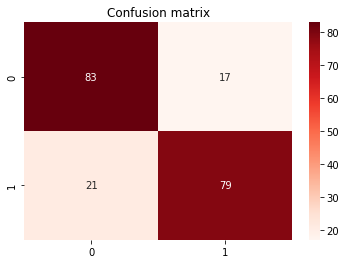

In [13]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,cmap="Reds",fmt='g')
plt.title('Confusion matrix', y=1)
plt.show()

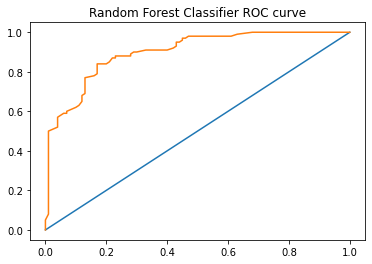

In [14]:
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.title('Random Forest Classifier ROC curve')
plt.show()

In [15]:
roc_auc_score(y_test,y_pred_proba)

0.8988

## XG Boost Base model

In [16]:
model_xg = xg.XGBClassifier()
model_xg.fit(X_train, y_train)
y_pred_xg = model_xg.predict(X_test)
print('The accuracy of the XG Boost Classifier is',metrics.accuracy_score(y_pred_xg,y_test))

C:\Users\vidis\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy of the XG Boost Classifier is 0.84


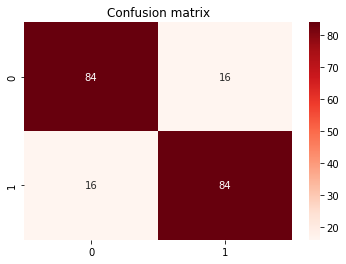

In [17]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_xg)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,cmap="Reds",fmt='g')
plt.title('Confusion matrix', y=1)
plt.show()

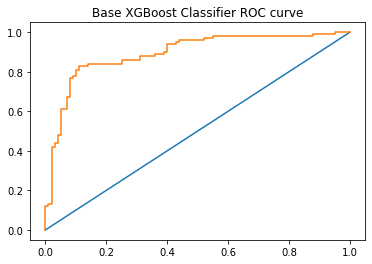

In [18]:
y_pred_proba = model_xg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.title('Base XGBoost Classifier ROC curve')
plt.show()

In [19]:
roc_auc_score(y_test,y_pred_proba)

0.8933

## Hyperparameter Tuning using grid search

In [20]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

## XG Boost Best Model

In [21]:
xgb_cl = xg.XGBClassifier(objective="binary:logistic")
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(X_train, y_train)


[00:05:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\vidis\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [22]:
grid_cv.best_score_

0.8624969729902131

In [23]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 7,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [24]:
final_cl = xg.XGBClassifier(
    **grid_cv.best_params_,
    objective="binary:logistic"
)

In [25]:
final_cl.fit(X_train, y_train)
pred_xg_final = final_cl.predict(X_test)

[00:05:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


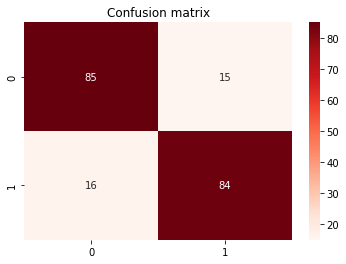

In [26]:
cnf_matrix = metrics.confusion_matrix(y_test, pred_xg_final)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,cmap="Reds",fmt='g')
plt.title('Confusion matrix', y=1)
plt.show()

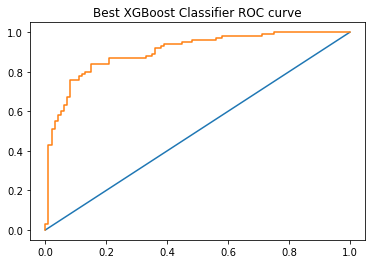

In [27]:
y_pred_proba = final_cl.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.title('Best XGBoost Classifier ROC curve')
plt.show()

In [28]:
roc_auc_score(y_test,y_pred_proba)

0.9016